Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.0766 - val_loss: 0.0339
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0576 - val_loss: 0.0310
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0521 - val_loss: 0.0276
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0654 - val_loss: 0.0236
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0532 - val_loss: 0.0182
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0361 - val_loss: 0.0102
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0294 - val_loss: 0.0038
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0299 - val_loss: 0.0286
Epoch 9/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0169 - val_loss: 0.0154
Epoch 10/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0104 - val_loss: 0.0279
Epoch 11/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0246 - val_loss: 0.1204
Epoch 12/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0232 - val_lo

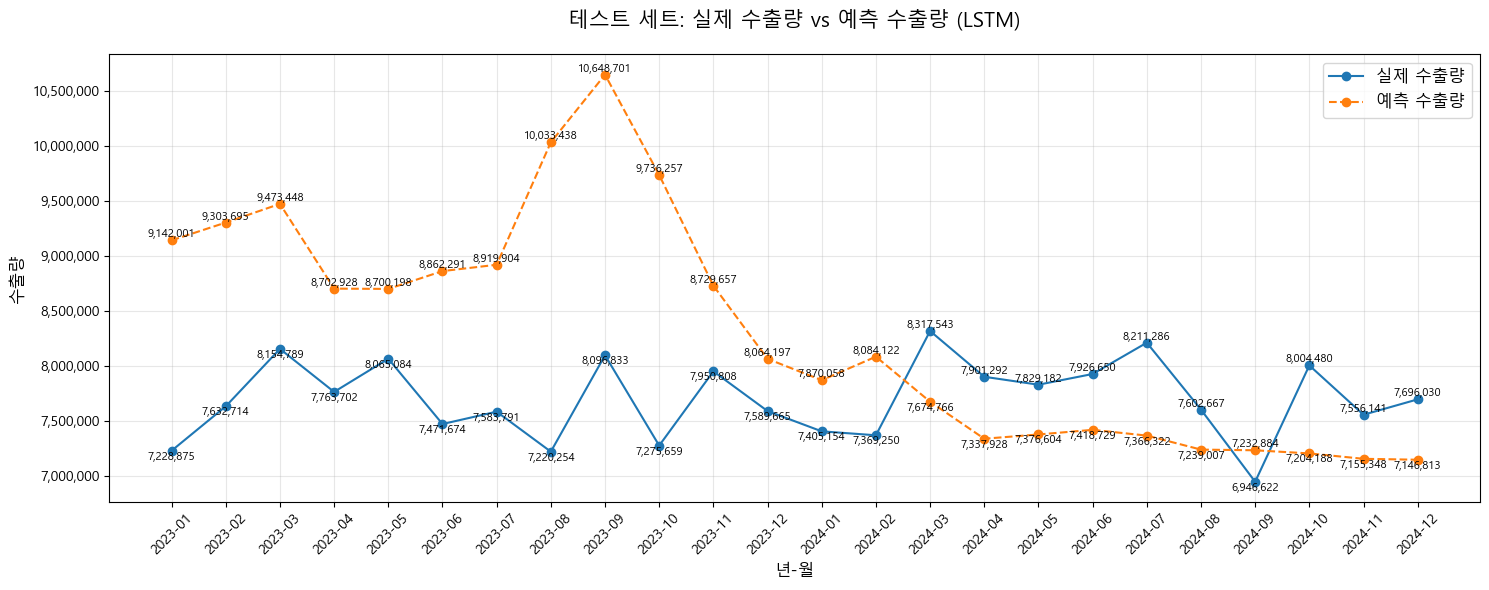


실제값과 예측값 비교 (LSTM):
             실제 수출량    예측 수출량
date                         
2023-01-01  7228875   9142001
2023-02-01  7632714   9303695
2023-03-01  8154789   9473448
2023-04-01  7763702   8702928
2023-05-01  8065084   8700198
2023-06-01  7471674   8862291
2023-07-01  7583791   8919904
2023-08-01  7220254  10033438
2023-09-01  8096833  10648701
2023-10-01  7275659   9736257
2023-11-01  7950808   8729657
2023-12-01  7589665   8064197
2024-01-01  7405154   7870058
2024-02-01  7369250   8084122
2024-03-01  8317543   7674766
2024-04-01  7901292   7337928
2024-05-01  7829182   7376604
2024-06-01  7926650   7418729
2024-07-01  8211286   7366322
2024-08-01  7602667   7239007
2024-09-01  6946622   7232884
2024-10-01  8004480   7204188
2024-11-01  7556141   7155348
2024-12-01  7696030   7146813


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM # LSTM 모델 사용
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
# 마이너스 부호 깨짐 방지
plt.rc('axes', unicode_minus=False)

# 데이터 로드
df = pd.read_csv('data_integ.csv', parse_dates=['date'])
df.set_index('date', inplace=True)


# 타겟 변수와 피쳐 분리
X = df.drop(columns=['export', 'export_restored'])
y = df['export_restored']

# 데이터 정규화 // 타겟 변수 제외 스케일링이 되어있기 때문에 타겟 변수만 스케일링
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 시계열 데이터 형태로 변환 (RNN 입력용)
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 3  # 시퀀스 길이 설정
X_seq, y_seq = create_sequences(X, y_scaled, time_steps)

# 학습/테스트 데이터 분할 (80:20)
split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# LSTM 모델 구성
model = Sequential([
    LSTM(256, activation='relu', input_shape=(time_steps, X.shape[1]), return_sequences=True),
    LSTM(128, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False), # 3차원 텐서를 그대로 Dense에 넣으면 ValueError 발생
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# 모델 학습
history = model.fit(X_train, y_train, 
                   epochs=200, 
                   batch_size=16,
                   validation_split=0.2,
                   verbose=1)

# 예측 수행
preds_scaled = model.predict(X_test)

# 예측값 역정규화 // 스케일링 해줬던 값을 원본으로 복구
preds = scaler_y.inverse_transform(preds_scaled)
y_test_original = scaler_y.inverse_transform(y_test)

# 모델 성능 평가
def get_reg_eval(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

get_reg_eval(y_test_original, preds)

# ---------------------- 여기서부터는 시각화 코드 ----------------------------
# 예측 결과와 실제 값을 포함한 DataFrame 생성
results_df = pd.DataFrame({
    '실제 수출량': y_test_original.flatten(),
    '예측 수출량': preds.flatten()
}, index=df.index[split_idx+time_steps:])

# 소수점 반올림 및 정수형 변환
results_df = results_df.round(0).astype(int)

# x축 눈금용 날짜 리스트 생성
dates = results_df.index.strftime('%Y-%m')

# 실제값과 예측값 시각화
plt.figure(figsize=(15, 6))

plt.plot(range(len(dates)), results_df['실제 수출량'], 
         marker='o', linestyle='-', label='실제 수출량', color='#1f77b4')
plt.plot(range(len(dates)), results_df['예측 수출량'], 
         marker='o', linestyle='--', label='예측 수출량', color='#ff7f0e')

# 실제값과 예측값 텍스트 표시
for i in range(len(dates)):
    real_val = results_df['실제 수출량'].iloc[i]
    pred_val = results_df['예측 수출량'].iloc[i]
    
    if real_val >= pred_val:
        plt.text(i, real_val, f'{real_val:,.0f}', 
                 verticalalignment='bottom', 
                 horizontalalignment='center',
                 fontsize=8)
        plt.text(i, pred_val, f'{pred_val:,.0f}', 
                 verticalalignment='top', 
                 horizontalalignment='center',
                 fontsize=8)
    else:
        plt.text(i, pred_val, f'{pred_val:,.0f}', 
                 verticalalignment='bottom', 
                 horizontalalignment='center',
                 fontsize=8)
        plt.text(i, real_val, f'{real_val:,.0f}', 
                 verticalalignment='top', 
                 horizontalalignment='center',
                 fontsize=8)

# 그래프 스타일링
plt.title('테스트 세트: 실제 수출량 vs 예측 수출량 (LSTM)', fontsize=15, pad=20)
plt.xlabel('년-월', fontsize=12)
plt.ylabel('수출량', fontsize=12)
plt.legend(prop={'size': 12})
plt.grid(True, alpha=0.3)

# x축 설정
plt.xticks(range(len(dates)), dates, rotation=45)

# y축 포맷팅 (천 단위 쉼표)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: format(int(x), ',')))

plt.tight_layout()
plt.show()

# 결과 출력
print("\n실제값과 예측값 비교 (LSTM):")
print(results_df.to_string(float_format=lambda x: '{:,.0f}'.format(x)))